# CLASS-HDS Demo

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from classy import Class

In [2]:
# Evoke class, set parameters and solve Einstein-Boltzmann

def get_hds_background(case):
    c = Class()
    if isinstance(case, int):
        phi_i = case
        pars = {
            # Cosmological parameters
            "H0": 67.56,
            "omega_b": 0.022,
            "omega_cdm": 0.12,
            "A_s": 2.215e-9,
            "n_s": 0.962,
            "tau_reio": 0.0544,
            "N_ur": 3.044,
            "N_ncdm": 0,
            "Omega_Lambda": 0.0,
            "Omega_fld": 0.0,
            "Omega_scf": -1.0, # NOTE: setting negative values of Omega_scf will trigger the shooting
            "scf_parameters": f"100,{phi_i}", # NOTE: scf_parameters is organized as follows: the first index represents V0 (it shoots so the value does not matter), the second represents the field initial value
            "YHe": 0.24,
            "scf_tuning_index": 0,
            # CLASS settings
            "lensing": "yes",
            "non_linear": "hmcode",
            "output": "mPk,tCl,pCl,lCl",
            "l_max_scalars": 3000,
            "P_k_max_h/Mpc": 10,
        }
    elif case == "LCDM":
        pars = {
            # Cosmological parameters
            "H0": 67.56,
            "omega_b": 0.022,
            "omega_cdm": 0.12,
            "A_s": 2.215e-9,
            "n_s": 0.962,
            "tau_reio": 0.0544,
            "N_ur": 3.044,
            "N_ncdm": 0,
            # "Omega_Lambda": 0.0,
            "Omega_fld": 0.0,
            "Omega_scf": 0.0, # NOTE: setting negative values of Omega_scf will trigger the shooting
            "YHe": 0.24,
            "scf_tuning_index": 0,
            # CLASS settings
            "lensing": "yes",
            "non_linear": "hmcode",
            "output": "mPk,tCl,pCl,lCl",
            "l_max_scalars": 3000,
            "P_k_max_h/Mpc": 10,
        }
    c.set(pars)
    c.compute()
    bg = c.get_background()
    return bg

def get_densities_from_bg(bg):
    z = bg["z"]
    rho_cdm = bg["(.)rho_cdm"]
    rho_b = bg["(.)rho_b"]
    rho_nu_massless = bg["(.)rho_ur"]
    rho_phot = bg["(.)rho_g"]
    if "(.)rho_scf" in bg.keys(): rho_de = bg["(.)rho_scf"]
    else: rho_de = bg["(.)rho_Lambda"]
    rho_tot = bg["(.)rho_tot"]
    return z, rho_cdm, rho_b, rho_phot+rho_nu_massless, rho_de, rho_tot

def get_fractions_from_bg(bg):
    z, rho_cdm, rho_b, rho_r, rho_de, rho_tot = get_densities_from_bg(bg)
    return z, rho_cdm/rho_tot, rho_b/rho_tot, rho_r/rho_tot, rho_de/rho_tot

def check_omegas(bg):
    z, f_cdm, f_b, f_r, f_scf = get_fractions_from_bg(bg)
    omega_m = (0.022 + 0.12)/(0.6756)**2
    omega_scf = 1 - omega_m - f_r[-1]
    actual_omega_m = f_cdm[-1] + f_b[-1]
    actual_omega_scf = f_scf[-1]
    print(f"Omega_m: expected {omega_m}, got {actual_omega_m}, relative error = {(actual_omega_m-omega_m)/omega_m}")
    print(f"Omega_de: expected {omega_scf}, got {actual_omega_scf}, relative error = {(actual_omega_scf-omega_scf)/omega_scf}")

In [3]:
cases = [8, 10, 15, 20]
bgs = {}
for case in cases:
    bgs[case] = get_hds_background(case)


In [4]:
a = 1/(1 + bg_8['z'])
plt.semilogx(a, bg_8['phi_scf']/8)
plt.semilogx(a, bg_10['phi_scf']/10)

NameError: name 'bg_8' is not defined

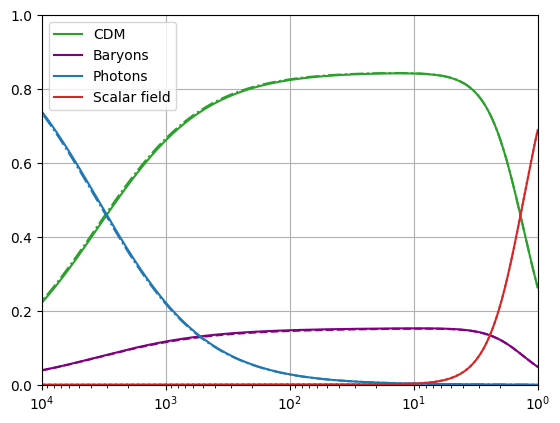

In [ ]:
# Figure 1 - left panel
z, rho_cdm_8, rho_b_8, rho_r_8, rho_scf_8, rho_tot_8 = get_densities_from_bg(bg_8)
z, rho_cdm_10, rho_b_10, rho_r_10, rho_scf_10, rho_tot_10 = get_densities_from_bg(bg_10)

plt.semilogx(1+z, rho_cdm_10/rho_tot_10, color="tab:green", label="CDM")
plt.semilogx(1+z, rho_cdm_8/rho_tot_8, color="tab:green", ls="-.")
plt.semilogx(1+z, rho_b_10/rho_tot_10, color="purple", label="Baryons")
plt.semilogx(1+z, rho_b_8/rho_tot_8, color="purple", ls="--")
plt.semilogx(1+z, rho_r_10/rho_tot_10, color="tab:blue", label="Photons")
plt.semilogx(1+z, rho_r_8/rho_tot_8, color="tab:blue", ls="-.")
plt.semilogx(1+z, rho_scf_10/rho_tot_10, color="tab:red", label="Scalar field")
plt.semilogx(1+z, rho_scf_8/rho_tot_8, color="tab:red", ls=":")
plt.xlim([1e4, 1])
plt.ylim([0, 1])
plt.legend()
plt.grid()

In [ ]:
# Figure 1 - right panels
z, rho_cdm_8, rho_b_8, rho_r_8, rho_scf_8, rho_tot_8 = get_densities_from_bg(bg_8)
z, rho_cdm_10, rho_b_10, rho_r_10, rho_scf_10, rho_tot_10 = get_densities_from_bg(bg_10)

plt.semilogx(1+z, rho_cdm_10/rho_tot_10, color="tab:green", label="CDM")
plt.semilogx(1+z, rho_cdm_8/rho_tot_8, color="tab:green", ls="-.")
plt.semilogx(1+z, rho_b_10/rho_tot_10, color="purple", label="Baryons")
plt.semilogx(1+z, rho_b_8/rho_tot_8, color="purple", ls="--")
plt.semilogx(1+z, rho_r_10/rho_tot_10, color="tab:blue", label="Photons")
plt.semilogx(1+z, rho_r_8/rho_tot_8, color="tab:blue", ls="-.")
plt.semilogx(1+z, rho_scf_10/rho_tot_10, color="tab:red", label="Scalar field")
plt.semilogx(1+z, rho_scf_8/rho_tot_8, color="tab:red", ls=":")
plt.xlim([1e4, 1])
plt.ylim([0, 1])
plt.legend()
plt.grid()

In [ ]:
# Checking the omegas
check_omegas(bg_8)
check_omegas(bg_10)

Omega_m: expected 0.31110648394988505, got 0.3111064839535105, relative error = 1.165335174273467e-11
Omega_de: expected 0.6888018801578264, got 0.6888018801542009, relative error = -5.263551702828081e-12
Omega_m: expected 0.31110648394988505, got 0.3111064839507205, relative error = 2.6853918806944846e-12
Omega_de: expected 0.6888018801578261, got 0.6888018801569906, relative error = -1.2128927781657683e-12


In [ ]:
# Extracting P(k) and temperature C_l
h = 0.6732
k = np.logspace(-3, 1, 200) # In h/Mpc
z = np.zeros(1)
pk = c.get_pk_array(k*h, z, len(k), 1, True) # NOTE: this function assumes k in 1/Mpc
class_cls = c.lensed_cl()
ells = class_cls['ell']
cls = ells*(ells+1)*class_cls['tt']/(2*np.pi)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].semilogx(ells, cls)
axs[1].loglog(k, pk)

NameError: name 'c' is not defined